In [1]:

import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path
from itertools import product as prod
# from tqdm import tqdm

from scipy.optimize import curve_fit
from scipy.linalg import expm
from scipy.integrate import quad
from colorsys import hls_to_rgb
import pickle, os, sys
import scipy.optimize
from scipy.interpolate import interp1d
from scipy.linalg import expm

sys.path.append("../common")
# sys.path.insert(0, "../")
# sys.path.insert(0, "../pyMMF")
from functions import (
    stack_correlation, 
    fidelity, 
    get_disk_mask,
    colorize,
    logplotTM,
    get_color_map,
    generate_color_shades,
    load_complex32
)

import pyMMF

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
pyMMF.__file__

'/opt/miniconda/py3/envs/py38/lib/python3.8/site-packages/pyMMF/__init__.py'

**Requires pyMMF**

In [3]:
FIBER = 'Draka-GRIN'
DATA_PATH = Path("../Data") / FIBER
# DATA_PATH = "../Data/"

# path to save images
IMAGE_FOLDER = Path("../images") / FIBER
os.makedirs(IMAGE_FOLDER, exist_ok=True)


def file_path(file_name):
    return os.path.join(DATA_PATH, file_name)


def image_path(file_name):
    return os.path.join(IMAGE_FOLDER, file_name)


**Parameters for plots**

In [4]:
REF_SIZE = 24
TICK_SIZE = REF_SIZE
LEGEND_SIZE = REF_SIZE - 4
LABEL_SIZE = REF_SIZE + 2
TITLE_SIZE = REF_SIZE + 2
SMALL_TITLE_SIZE = REF_SIZE
TINY_TITLE_SIZE = REF_SIZE - 4
SUP_TITLE_SIZE = REF_SIZE + 6
FIGSIZE = (8, 5)
SAVE_FIG = True

In [5]:
def get_rotation_matrix(m, l, alpha):
    return np.diag(np.exp(1j*np.array(m)*alpha))

def sort(A):
    return A[ml_sorted_idx,:][:,ml_sorted_idx]

def leq(A,l_val):
    ind = select_l(l_val)
    return A[ind,:][:,ind]

def leq1(A):
    return leq(A,1)

def meq0(A):
    return A[meq0_sorted_idx,:][:,meq0_sorted_idx]

def ipr_m(A):
    # I = np.abs(A)**2
    # return np.sum(I*deltaM)**2/np.sum(I**2)
    dm_max = int(np.max(deltaM))
    I_dm = []
    for dm in range(dm_max+1):
        mask = deltaM == dm
        I_dm.append(np.sum(mask*np.abs(A)**2)/np.sum(mask))
    I_dm = np.array(I_dm)
    return np.sum(I_dm**2)/np.sum(I_dm)**2
    
def corr(A,B):
    A = A - np.mean(A)
    B = B - np.mean(B)
    return np.sum(A*B.conjugate())/np.sqrt(np.sum(A*A.conjugate())*np.sum(B*B.conjugate()))

In [6]:
data2save = {}
def save_data():
    pickle.dump(
        data2save,
        open(DATA_PATH / "processed_data.pkl", "wb") 
    )

# I. Simulation of the fiber modes

## A. Simulation parameters 
(to match the experimental fiber)

In [7]:
NA = 0.2
radius = 25 # in microns
areaSize = 2.4*radius # calculate the field on an area larger than the diameter of the fiber
npoints = 2**8 # resolution of the window
n1 = 1.45
wl = 1.55 # wavelength in microns
curvature = None
k0 = 2.*np.pi/wl


r_max = 3.2*radius
npoints_search = 2**8
dh = 2*radius/npoints_search

## B. Find modes of straight fiber

### B.1 Create the fiber index profile

In [8]:
profile = pyMMF.IndexProfile(npoints = npoints, areaSize = areaSize)
profile.initParabolicGRIN(n1=n1, a=radius, NA=NA)

### B.2 Instantiate the solver

In [9]:
solver = pyMMF.propagationModeSolver()
solver.setIndexProfile(profile)
solver.setWL(wl)

2023-08-21 12:49:11,844 - pyMMF.core [DEBUG  ]  Debug mode ON.


### 1.2.3 Run the solver

In [10]:
modes = solver.solve(
        mode='radial_test',
        curvature = None,
        r_max = r_max, # max radius to calculate (and first try for large radial boundary condition)
        dh = dh, # radial resolution during the computation
        min_radius_bc = .5, # min large radial boundary condition
        change_bc_radius_step = 0.85, #change of the large radial boundary condition if fails 
        N_beta_coarse = int(1e3), # number of steps of the initial coarse scan
        degenerate_mode = 'exp',
        save_radial = True,
        )

nmodes = modes.number

2023-08-21 12:49:12,348 - pyMMF.solv [INFO   ]  Found 5 radial mode(s) for m=0
2023-08-21 12:49:12,348 - pyMMF.solv [INFO   ]  Searching propagation constant for |l| = 1
2023-08-21 12:49:12,413 - pyMMF.solv [ERROR  ]  Field limit 1.0 at the founded beta=0.05066217542815342 is greater than field_limit_tol=0.001
2023-08-21 12:49:12,446 - pyMMF.solv [WARNING]  Boundary condition could not be met.
2023-08-21 12:49:12,499 - pyMMF.solv [WARNING]  Retrying by changing r_max to 2.72a
2023-08-21 12:49:12,572 - pyMMF.solv [ERROR  ]  Field limit 1.0 at the founded beta=0.05066217542815342 is greater than field_limit_tol=0.001
2023-08-21 12:49:12,596 - pyMMF.solv [WARNING]  Boundary condition could not be met.
2023-08-21 12:49:12,621 - pyMMF.solv [WARNING]  Retrying by changing r_max to 2.31a
2023-08-21 12:49:12,640 - pyMMF.solv [ERROR  ]  Field limit 0.7012700255083901 at the founded beta=0.05066217542815342 is greater than field_limit_tol=0.001
2023-08-21 12:49:12,663 - pyMMF.solv [WARNING]  Bou

### 1.2.4 Retrieve the modes

In [11]:
M = modes.getModeMatrix()
l=modes.l
m=modes.m
ml = list(zip(m, l) )
TM_mode = modes.getPropagationMatrix(distance = 100)

In [12]:
data2save['modes'] = {
    'm': m,
    'l': l,
    'ml': ml,
    'betas': modes.betas,
    'M': M,
}

save_data()

In [13]:
# modes2 = np.load(DATA_PATH / "modes.npz")
# Mout = modes2["modes_out"].astype(np.complex64)
# m2 = modes2["m"]
# l2 = modes2["l"]
# M2 = modes2['modes_out']
# betas2 = 
# data2save['modes'] = 
# {

# }

In [14]:
ml_indexed = [[i, x] for i,x in enumerate(ml)]
ml_indexed_sorted = sorted(ml_indexed, key = lambda x: x[1][0])
# ind = np.argsort(np.array(ml), axis = 0)
ml_sorted_idx = [x[0] for x in ml_indexed_sorted]
# ml_sorted_idx
def select_l(l_val):
    return [x[0] for x in ml_indexed_sorted if x[1][1] == l_val]
leq1_sorted_idx = select_l(1)
meq0_sorted_idx = [x[0] for x in ml_indexed_sorted if x[1][0] == 0]

In [15]:
# matrix containing the difference of m (OAM) number between pairs of modes
deltaM = np.zeros((nmodes, nmodes), dtype = float)
for i_val1,m_val1 in enumerate(m):
    for i_val2, m_val2 in enumerate(m):
        deltaM[i_val1, i_val2] = m_val1-m_val2
        
# matrix containing the difference of propagation constants beta between pairs of modes
deltaBeta = np.zeros((nmodes, nmodes), dtype = float)
for i_val1, beta_val1 in enumerate(modes.betas):
    for i_val2, beta_val2 in enumerate(modes.betas):
        deltaBeta[i_val1, i_val2] = beta_val1-beta_val2

# matrix containing the difference of l (radial momentum) number beta between pairs of modes
deltaL = np.zeros((nmodes, nmodes), dtype = float)
for i_val1, l_val1 in enumerate(l):
    for i_val2, l_val2 in enumerate(l):
        deltaL[i_val1, i_val2] = l_val1-l_val2

def get_mask_l(l_val = None):
    mask = np.zeros((nmodes, nmodes), dtype = int)
    assert l_val is not None or m_val is not None 
    for i_val1, (m_val1, l_val1) in enumerate(ml):
        for i_val2, (m_val2, l_val2) in enumerate(ml):
            if l_val1 == l_val and l_val2 == l_val:
                 mask[i_val1, i_val2] = 1
    return mask





### 1.2.5 Useful functions

# II. Experimental data

## A. Load data

### A.1. Load parameters of the fiber and the experiment

In [16]:
with open(file_path("param.pkl"), "rb") as file:
    param = pickle.load(file, encoding="latin1")


# number of pixels in each axis in the input plane (DMD)
N_in = param["fiber"]["inpoints"]
# number of pixels in each axis in the output plane (camera)
N_out = param["fiber"]["onpoints"]

# angles of rotation of the input wavefronts
angles = param["RME"]["angles"]
n_a = param["RME"]["n_angles"]
# number of random input wavefronts
n_rnd = param["RME"]["n_rnd"]
nv_max = param["RME"]["nv_max"]

# number of operatoirs
n_op = param["RME"]["n_op"]
# number of the first modes of each operator sent to the DMD
n_rm = param["RME"]["n_rm"]
n_angles_for_corr = param["RME"]["n_ang_corr"]


# load parameters associated with the shrinked data files
with open(file_path("param_small.pkl"), "rb") as file:
    param = pickle.load(file, encoding="latin1")

# number of deformation values stored in the demo
# (the actual full dataset has 30 deformation values)
n_defomr = param["n_deform"]

# deformation indices used in the demo
deformation_indices = param["deformation_indices"]
# deformation_indices = [0,3]

# deformation values
Delta_x = param["Delta_x"]


In [17]:
with open(file_path("param.pkl"), "rb") as file:
    param = pickle.load(file, encoding="latin1")

param['fiber']

{'NA': 0.2,
 'radius': 25.6,
 'name': 'DRAKA-GRIN',
 'type': 'GRIN',
 'wl': 1.55,
 'n1': 1.4545,
 'curvature': None,
 'length': 2500000.0,
 'ipitch': 2.232,
 'opitch': 1.2480000000000002,
 'inpoints': 30,
 'onpoints': 49}

### A.2 Load the measured output fields corresponding to rotated inputs for different deformations 

**load and concatenate the measurements for random input at different levels of deformation**

In [18]:
filepaths = glob.glob(file_path("Ys_rnd_small_p1_*.npz"))
arrays = []
for filepath in filepaths:
    data = np.load(filepath)
    arr = load_complex32(filename=filepath)
    arrays.append(arr)
Ys_rnd_p1 = np.stack(arrays, axis=0)
# move the axis so that the penultimate one corresponds to angles
Ys_rnd_p1 = np.moveaxis(Ys_rnd_p1, -3, -2)

filepaths = glob.glob(file_path("Ys_rnd_small_p2_*.npz"))
arrays = []
for filepath in filepaths:
    data = np.load(filepath)
    arr = load_complex32(filename=filepath)
    arrays.append(arr)
Ys_rnd_p2 = np.stack(arrays, axis=0)
# move the axis so that the penultimate one corresponds to angles
Ys_rnd_p2 = np.moveaxis(Ys_rnd_p2, -3, -2)

**Concatenate the two polarizations to have the full output fields**

In [19]:
Ys_rnd = np.concatenate((Ys_rnd_p1, Ys_rnd_p2), axis=-1)

### A.3 Load the TMs in the mode basis

In [20]:
TMs_mode = np.load(os.path.join(DATA_PATH, "TMs_mode.npy")).astype(np.complex64)
n_modes = TMs_mode.shape[-1]
# select one polarization, and take only the deformation values used in the demo
TMs = TMs_mode[deformation_indices, :n_modes, :]

In [21]:
# Min_corr = data['modes_in_corr']
# Min = data['modes_in']

## B. Experimentally measured RME correlation

### B.1 Average output intensity for random inputs wavefronts

We excite from one circular polarization and measure both at the output

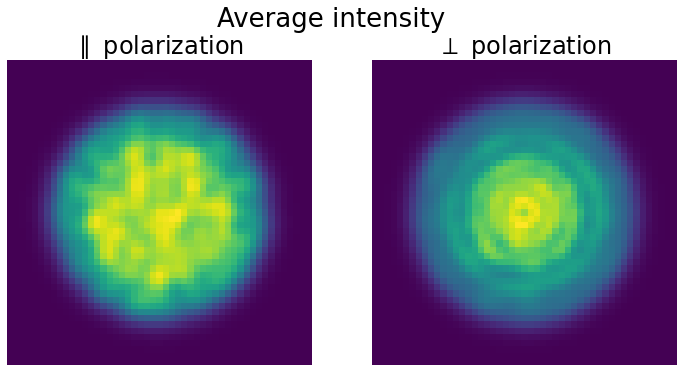

In [22]:
mask_corr = get_disk_mask([N_out, N_out],0.74*N_out/2)
mask_corr_2p = np.concatenate((mask_corr,mask_corr), axis=0)
I_mean = np.mean(np.abs(Ys_rnd[0])**2, axis=(0,1)).reshape((N_out*2,N_out))
I_mean_p1 = I_mean[:N_out,:]
I_mean_p2 = I_mean[N_out:,:]
plt.figure(figsize = (12,6))
plt.subplot(121)
plt.imshow(I_mean_p1)
plt.axis('off')
plt.title(r'$\parallel$ polarization', fontsize = SMALL_TITLE_SIZE)
plt.subplot(122)
plt.imshow(I_mean_p2)
plt.axis('off')
plt.title(r'$\perp$ polarization', fontsize = SMALL_TITLE_SIZE)
plt.suptitle('Average intensity', fontsize = TITLE_SIZE);

## B.2 Field correlation

In [23]:
# field correlation
Ys_rnd_ref_p1 = Ys_rnd_p1[...,0,:]
rnd_corr_p1 = stack_correlation(Ys_rnd_p1, Ys_rnd_ref_p1)

Ys_rnd_ref_p2 = Ys_rnd_p2[...,0,:]
rnd_corr_p2 = stack_correlation(Ys_rnd_p2, Ys_rnd_ref_p2)
# intensity correlation
rndint_corr_p1 = stack_correlation(
    np.abs(Ys_rnd_p1)**2, 
    np.abs(Ys_rnd_ref_p1)**2
)

#### Compute RME field correlations for both output polarizations

In [24]:
Corr_mean_exp = np.mean(np.abs(rnd_corr_p1),axis=-2)
Corr_std_exp = np.std(np.abs(rnd_corr_p1),axis=-2)

Corr_mean_exp_p2 = np.mean(np.abs(rnd_corr_p2),axis=-2)
Corr_std_exp_p2 = np.std(np.abs(rnd_corr_p2),axis=-2)

data2save['exp'] = {
    'Corr_mean': Corr_mean_exp,
    'Corr_std': Corr_std_exp,
    'angles': angles,
}
save_data()

#### Show the results

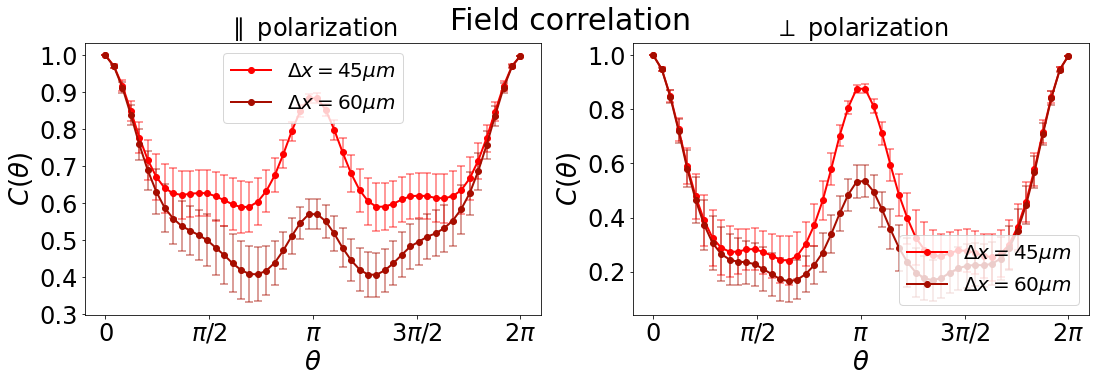

In [25]:
def plot_error(y, y_err, color):
    plt.errorbar(angles,y  , yerr=y_err, color = color,
        linewidth = 2,
        linestyle = 'None', 
        capsize = 4,
        capthick = 2,
        alpha = 0.4)

def show_RME_corr_2pola(show_error=True, save_fig=True):
    deformations2show = [2, 3]
    # colors = generate_color_shades('PuRd', 4)
    cmap = get_color_map(n=len(deformations2show) + 1)
    plt.figure(figsize=(18, 5))
    plt.subplot(121)
    for ind_color, ind_deformation in enumerate(deformations2show):
        color = cmap(ind_color)
        plt.errorbar(
            angles,
            Corr_mean_exp[ind_deformation],
            label=rf"$\Delta x = {Delta_x[ind_deformation]:.0f} \mu m$",
            color=color,
            marker="o",
            linewidth=2,
        )
        if show_error:
            plot_error(
                Corr_mean_exp[ind_deformation],
                Corr_std_exp[ind_deformation],
                color=color,
            )
    plt.xlabel(r"$\theta$", fontsize=LABEL_SIZE)
    plt.ylabel(r"$C(\theta)$", fontsize=LABEL_SIZE)
    xticks = [0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi]
    xtics_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]
    plt.xticks(xticks, xtics_labels, fontsize=TICK_SIZE)
    plt.yticks(fontsize=TICK_SIZE)
    plt.legend(fontsize=LEGEND_SIZE)
    plt.title(r"$\parallel$ polarization", fontsize=SMALL_TITLE_SIZE)

    plt.subplot(122)
    for ind_color, ind_deformation in enumerate(deformations2show):
        color = cmap(ind_color)
        plt.errorbar(
            angles,
            Corr_mean_exp_p2[ind_deformation],
            label=rf"$\Delta x = {Delta_x[ind_deformation]:.0f} \mu m$",
            color=color,
            marker="o",
            linewidth=2,
        )
        if show_error:
            plot_error(
                Corr_mean_exp_p2[ind_deformation],
                Corr_std_exp_p2[ind_deformation],
                color=color,
            )
    plt.xlabel(r"$\theta$", fontsize=LABEL_SIZE)
    plt.ylabel(r"$C(\theta)$", fontsize=LABEL_SIZE)
    xticks = [0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi]
    xtics_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]
    plt.xticks(xticks, xtics_labels, fontsize=TICK_SIZE)
    plt.yticks(fontsize=TICK_SIZE)
    plt.legend(fontsize=LEGEND_SIZE, loc="lower right")
    plt.title(r"$\perp$ polarization", fontsize=SMALL_TITLE_SIZE)

    plt.suptitle("Field correlation", fontsize=SUP_TITLE_SIZE)

    if save_fig:
        plt.savefig(
            image_path(f"RMEcorr_Vs_deform.svg"),
            dpi=300,
        )


show_RME_corr_2pola(show_error=True, save_fig=SAVE_FIG)

In [26]:
nmodes = TMs_mode.shape[-1]
TMs_pola1 = TMs_mode[:,:nmodes, :] 
TMs_pola2 = TMs_mode[:,nmodes:, :]

# III. Theoretical predictions and fit


$$
    C(\theta) =  1+
        A\sum_q \Gamma_q^2 (\cos(q\theta)-1) B_{\gamma\alpha}(q)
$$

with 
$$
    A = (k_0 l_z)^2 \frac{L}{l_z}
$$

and

$$
    B_{\gamma\alpha} = \sum_{\alpha,\gamma/\left|m_\gamma-m_\alpha\right|=q} \text{sinc}^2\left(\frac{\beta_\gamma-\beta_\alpha}{2}\right) I_{\gamma\alpha}
$$

$$
I_{\gamma\alpha} = \frac{1}{N_{modes}} 
    \int_0^a dr \left|a_\gamma(r)\right|^2 \left|a_\alpha(r)\right|^2 r^2
    \int_{-\infty}^\infty dr' \left\langle f_p(r) f_p(r+r') \right\rangle
$$

$$
    \int_{-\infty}^\infty dr' \left\langle f_p(r) f_p(r+r') \right\rangle 
    \approx 4 \left(\frac{\Delta n r}{a^2}\right)^2 d_\text{layer}^3
$$

for a radial disorder of the form


$$
    f_p(r) = \frac{d n}{d r} d_\text{layer} b(r)
$$

with $b(r)$ a Gaussian noise so that 

$$
\left\langle b(r) b(r+r') \right\rangle  \approx d_\text{layer} \delta(r')
$$


## A. Parameters

In [27]:
# total fiber length
L_tot = 2.45e4 #um
# correlation length in the z direction 100 umn
dz = 1e2 #um
# 
d_layer = 1
# discretization of the radial disorder
# # dr = 5*dh
# dr = d_layer#5 * dh
# number of max gamma parameters to consider
# n_gamma_params = 5
# dr = d_layer


In [28]:
# from findiff import FinDiff


# r_vec = np.arange(0, r_max, dr)

# f_n = profile.radialFunc
# d_dr = FinDiff(0, dr)
# dn1 = d_dr(np.array([f_n(r) for r in r_vec]))


# fdn = lambda r: -2*r/(radius**2) * Dn * (r > 0) * (r < radius)
# plt.figure(figsize = (20,7))
# plt.plot(r_vec, dn1)
# plt.plot(r_vec, fdn(r_vec))

## B. Computation of the mode dependent terms

In [29]:
def radial_norm(t, r_vec, d):
    return np.sqrt(2*np.pi*np.sum(np.abs(t) ** 2 * r_vec)*d)


def get_norm_func_radial(f, dh, r_max):
    r_vec = np.arange(0, r_max, d)
    t = f(r_vec)
    return radial_norm(t, r_vec, d)


def normalize_r(t, r_vec, d):
    return t / radial_norm(t, r_vec, d)

def normalize_fr(f):
    return lambda x: f(x) / np.linalg.norm(f(profile.R))   

sinc = lambda x: np.sinc(x/np.pi)


# discretization of the radial coordinate
dr = 1e-2
r_max = modes.data[0]['r_max']
r_vec = np.arange(0, r_max, dr)

# difference of refractive index between the axis (maximum value) and the cladding (minimum value)
Dn = NA**2/(2.*n1)


noise_std = lambda r: -2*r/(radius**2) * Dn * d_layer * (r > 0) * (r < radius)


# radial profiles of the modes
M = np.array(
    [data["radial_func"](r_vec) for data in modes.data]
)

# normalization of the radial profile
M = M.transpose() / np.sqrt(np.sum(np.abs(M)**2*r_vec*dr, axis = 1))#np.linalg.norm(M*r_vec, axis = 1)
M = M.transpose()

MsqR = M**2 * r_vec  * noise_std(r_vec)

# I = MsqR@MsqR.transpose()*R0*dr
I = MsqR@MsqR.transpose()*d_layer*dr #*dr#/np.sqrt(d_layer)
# beta dependence
mask_beta = sinc(deltaBeta/2*dz)**2

# coefficient A
coeff = L_tot/dz*(k0*dz)**2*1/nmodes*.25

# q values to consider in the azimuthal series decomposition
qs =  (1,2,3,4) 

In [30]:
# def Compute_correlation(gammas, qs, normalize = True):
#     C = []
#     for q, gamma in zip(qs, gammas):
#         mask_M = (np.abs(deltaM) == q)
#         A = np.sum(mask_beta*mask_M*I) or 0.
#         cq = gamma**2*np.cos(q*angles)*A
#         # cq = gamma**2*(np.cos(q*angles)-1)*A
#         C.append(cq)
#     C = 1+coeff*np.array(C).sum(axis = 0)  
#     if normalize:
#         C = C/C[0]
#         C = C-C[0]+1
#     return C


In [31]:
# Compute_corr_from_coeffs([0,0,0,0], qs)

# alphas = []
# for ind_deform, Cref in enumerate(Corr_mean_exp):
    
#     err = lambda x: Correlation_error(x, qs, Cref = Cref)
#     initial_guess = n_coeffs_fit[-1] if ind_deform > 0 else [0.1]*len(qs)
#     xopt = scipy.optimize.fmin(func=err, x0=initial_guess)
#     alphas.append(np.abs(np.array(xopt)))
#     # print('['+','.join([str(g) for g in xopt ])+']')

# alphas = np.stack(alphas, axis = 0)

# # alpha = alphas[0][0]

# def get_gammas(alphas):
#     shape = alphas.shape
#     gammas = []
#     for alpha in alphas.ravel():
#         coeff_poly_root = [-x for x in poly_coeffs] + [alpha]
#         roots = np.roots(coeff_poly_root)

#         print('==>', roots)
#         ind_root = np.argmin(np.abs(np.imag(roots)))
#         gamma = np.sqrt(np.real(roots[ind_root]))
#         f = lambda x: np.abs((x**2 - 4 * x**4) - alpha)**2
#         # gamma = scipy.optimize.fmin(func=f, x0=0.1)
#         print('----> ', gamma)
#         gammas.append(gamma)
#     return np.array(gammas).reshape(shape)
# # alphas

# n_coeffs_fit = get_gammas(alphas)

In [32]:
# n_coeffs_fit = np.real(n_coeffs_fit)

# ind_deformation = 0
# plt.figure(figsize = (15,7))
# X = poly_gamma(n_coeffs_fit[ind_deformation])
# A = alphas[ind_deformation]
# plt.plot(angles, Compute_corr_from_coeffs(A, qs), linewidth = 3)
# plt.plot(angles, Compute_corr_from_coeffs(X, qs), 'r.-')
# print(A)
# print(X)
# # plt.plot(angles, Compute_correlation(n_coeffs_fit[ind_deformation], qs))
# # plt.plot(
# #     angles,
# #     Corr_mean_exp[ind_deformation],
# #     'r--',
# # )

In [33]:
eps = np.finfo(float).eps
mask_beta_sqrt = sinc(deltaBeta / 2 * dz)
mask_beta_cos = np.cos(deltaBeta / 2 * dz)
mask_beta_over = (np.abs(deltaBeta) > 0) * (1 / (deltaBeta**2 + eps))
Nz = L_tot / dz
c2 = Nz * 1 / 8 * k0 ** 4 * 1 / nmodes
A1 = (Nz - 1) / 2 * dz**4 * np.einsum("ab,cb->abc", mask_beta_sqrt, mask_beta_sqrt)
Itot = np.einsum("abc,ab,cb->abc", A1, I, I)


def Compute_correlation(gammas, qs):
    # First order
    minus_0 = 0
    C1 = None
    for q, gamma in zip(qs, gammas):
        mask_M = np.abs(deltaM) == q

        A = np.sum(mask_beta * mask_M * I) or 0.0
        # cq = gamma**2*(np.cos(q*angles)-1)*A
        cq = gamma**2*(np.cos(q*angles)-minus_0)*A
        # # cq = (gamma**2 - 4 * gamma**4) * (np.cos(q * angles) - 1) * A
        # # cq = poly_gamma(gamma) * (np.cos(q * angles) - 1) * A
        C1 = cq if C1 is None else C1+cq

    # second order
    C2 = None
    for (iq, q), (ir, r) in prod(enumerate(qs), enumerate(qs)):
        mask_Mq = deltaM == q
        mask_Mr1 = deltaM == r
        mask_Mr2 = deltaM == -r
        # mask_M_3d = np.einsum("ab, cb->abc", mask_M2, mask_M)

        
        # A2 = dz**2 * (    
        #     np.einsum("ac,ab->abc", mask_beta_over, mask_beta)
        #     + np.einsum("ac,cb->abc", mask_beta_over, mask_beta)
        #     - 2
        #     * np.einsum(
        #         "ac,ab,cb,ac->abc",
        #         mask_beta_over,
        #         mask_beta_sqrt,
        #         mask_beta_sqrt,
        #         mask_beta_cos,
        #     )
        # )
        
        if r == 0:
            C2qr = np.einsum("abc,ab,cb", Itot, mask_Mq, mask_Mr1) * (np.cos((q + r) * angles) -minus_0) * gammas[ir]**2 * gammas[iq]**2
        else:
            C2qr = np.einsum("abc,ab,cb", Itot, mask_Mq, mask_Mr1) * (np.cos((q + r) * angles) -minus_0 ) * gammas[ir]**2 * gammas[iq]**2
            + np.einsum("abc,ab,cb", Itot, mask_Mq, mask_Mr2) * (np.cos((q - r) * angles) - minus_0 ) * gammas[ir]**2 * gammas[iq]**2


        C2 = C2qr if C2 is None else C2+C2qr

    C = 1 + coeff * C1 #- .5*c2 * C2
    C = C/C[0]

    return C#, coeff * C1, c2*C2


q = 1



In [34]:
# ind_deform = 2
# gammas = np.copy(n_coeffs_fit[ind_deform])
# Corr_theory[0] =  Compute_correlation(gammas, qs) 
# show_RME_corr( show_error=True, ind_deformation = ind_deform, save_fig = True)

In [35]:
# C, C1, C2 = Compute_correlation([1e-1,4e-1,0,0], qs)
# plt.figure(figsize = (15,6))
# plt.plot(angles, C1)
# plt.plot(angles, C2)
# plt.plot(angles, C)

In [36]:
# a = np.sqrt(np.ceil(L_tot/dz))/3
# poly_coeffs = [a**2, -a, 1]
# poly_gamma =  lambda gamma: np.sum([c*gamma**(2*(i+1)) for i, c in enumerate(poly_coeffs[::-1])], axis = 0)
# # poly_gamma =  lambda gamma: gamma**2 - 4 * gamma**4 + 16*gamma**6


# def Compute_correlation(gammas, qs, normalize=True):
#     C = []
#     for q, gamma in zip(qs, gammas):
#         mask_M = np.abs(deltaM) == q
#         A = np.sum(mask_beta * mask_M * I) or 0.0
#         # cq = gamma**2*np.cos(q*angles)*A
#         # cq = (gamma**2 - 4 * gamma**4) * (np.cos(q * angles) - 1) * A
#         cq = poly_gamma(gamma) * (np.cos(q * angles) - 1) * A
#         C.append(cq)
#     C = 1 + coeff * np.array(C).sum(axis=0)
#     return C

def Compute_correlation_approx(gammas, qs, normalize=True):
    C = []
    for q, gamma in zip(qs, gammas):
        mask_M = np.abs(deltaM) == q
        A = np.sum(mask_beta * mask_M * I) or 0.0
        # cq = gamma**2*np.cos(q*angles)*A
        # cq = (gamma**2 - 4 * gamma**4) * (np.cos(q * angles) - 1) * A
        X = (q * angles)
        cq = -poly_gamma(gamma) * X**2/2 * A
        C.append(cq)
    C = 1 + coeff * np.array(C).sum(axis=0)
    C = C *  (C > 0)
    return C


def Correlation_error(gammas, qs, Cref):
    # C = Compute_correlation(gammas, qs)
    C = Compute_correlation(gammas, qs)
    error = np.mean(np.abs(Cref - C) ** 2)
    return error


# def Compute_corr_from_coeffs(alphas, qs):
#     return 1 + coeff*np.array(
#         [
#             alpha
#             * (np.cos(q * angles) - 1)
#             * np.sum(mask_beta * (np.abs(deltaM) == q) * I)
#             for q, alpha in zip(qs, alphas)
#         ]
#     ).sum(axis=0)


err = lambda x: Correlation_error(x, qs, Cref=Corr_mean_exp[0])


# nn = 12 * np.array([1e-2, 2e-2, 1e-2, 2e-2])
# C1 = Compute_correlation(nn, qs)
# Ca = Compute_correlation_approx(nn, qs)

# plt.figure(figsize=(8*2,5*2))


# plt.errorbar(
#     angles,
#     C1,
#     label=rf'Fit',
#     color = 'red',
#     marker='o',
#     linewidth=2,
# )
# plt.errorbar(
#     angles,
#     Ca,
#     label=rf'Approx',
#     color = 'green',
#     marker='o',
#     linewidth=2,
# )
# plt.ylim([0.8, 1])



In [37]:
# model_mats = []
# alphas = []
# for q, gamma in zip(qs, gammas):
#     mask_M = np.abs(deltaM) == q
#     A = np.sum(mask_beta * mask_M * I) or 0.0
#     alphas.append(poly_gamma(gamma))
#     mat = coeff* A
#     model_mats.append(mat)


## C. Fit the experimenta results with the theoretical model

### C.1 Error function 
Computes the quadratic error between two correlation curves 

### C.2 Fit the experimental data for different deformations

In [38]:
gammas = []
for ind_deform, Cref in enumerate(Corr_mean_exp):
    err = lambda x: Correlation_error(x, qs, Cref=Cref)
    initial_guess = gammas[-1] if ind_deform > 0 and gammas else [0.1] * len(qs)
    xopt = scipy.optimize.fmin(func=err, x0=initial_guess)
    gammas.append(np.abs(np.array(xopt)))

gammas = np.stack(gammas, axis=0)
n_coeffs_fit = gammas
# alpha = alphas[0][0]


Optimization terminated successfully.
         Current function value: 0.000112
         Iterations: 168
         Function evaluations: 286
Optimization terminated successfully.
         Current function value: 0.000110
         Iterations: 64
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 0.000110
         Iterations: 99
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: 0.000130
         Iterations: 115
         Function evaluations: 196
Optimization terminated successfully.
         Current function value: 0.000220
         Iterations: 113
         Function evaluations: 194


In [39]:
# Compute_corr_from_coeffs([0, 0, 0, 0], qs)

# alphas = []
# for ind_deform, Cref in enumerate(Corr_mean_exp):
#     err = lambda x: Correlation_error(x, qs, Cref=Cref)
#     initial_guess = alphas[-1] if ind_deform > 0 and alphas else [0.1] * len(qs)
#     xopt = scipy.optimize.fmin(func=err, x0=initial_guess)
#     alphas.append(np.abs(np.array(xopt)))

# alphas = np.stack(alphas, axis=0)

# alpha = alphas[0][0]


# def get_gammas(alphas):
#     shape = alphas.shape
#     gammas = []
#     for alpha in alphas.ravel():
#         coeff_poly_root = [-x for x in poly_coeffs] + [alpha]
#         roots = np.roots(coeff_poly_root)

#         ind_root = np.argmin(np.abs(np.imag(roots)))
#         gamma = np.sqrt(np.real(roots[ind_root]))
#         gammas.append(gamma)
#     return np.array(gammas).reshape(shape)


# alphas


# n_coeffs_fit = get_gammas(alphas)

# def get_model_mats():
#     model_mats = []
#     for q, alpha in zip(qs, alphas):
#         mask_M = np.abs(deltaM) == q
#         A = np.sum(mask_beta * mask_M * I) or 0.0
#         mat = coeff* A
#         model_mats.append(mat)
#     return model_mats

# model_mats = get_model_mats()



In [40]:

# Corr_theory = np.stack([Compute_correlation(gammas, qs) for gammas in n_coeffs_fit], axis = 0)

Corr_theory = np.stack([Compute_correlation(gammas, qs) for gammas in n_coeffs_fit], axis = 0)

# Corr_approx_small_angles =  np.stack([Compute_correlation_approx(gammas, qs) for gammas in n_coeffs_fit], axis = 0)

data2save['theo'] = {
    'Corr_mean': Corr_theory,
    # 'Corr_approx_small_angles': Corr_approx_small_angles,
    'gammas': n_coeffs_fit,
    # 'alphas': alphas,
    # 'model_mats': model_mats,
    'qs': qs,
    # 'angles': angles,
}



save_data()

[0.09803394995372214,
 0.01700518348930781,
 0.0022604454937682683,
 0.002198690683770428]

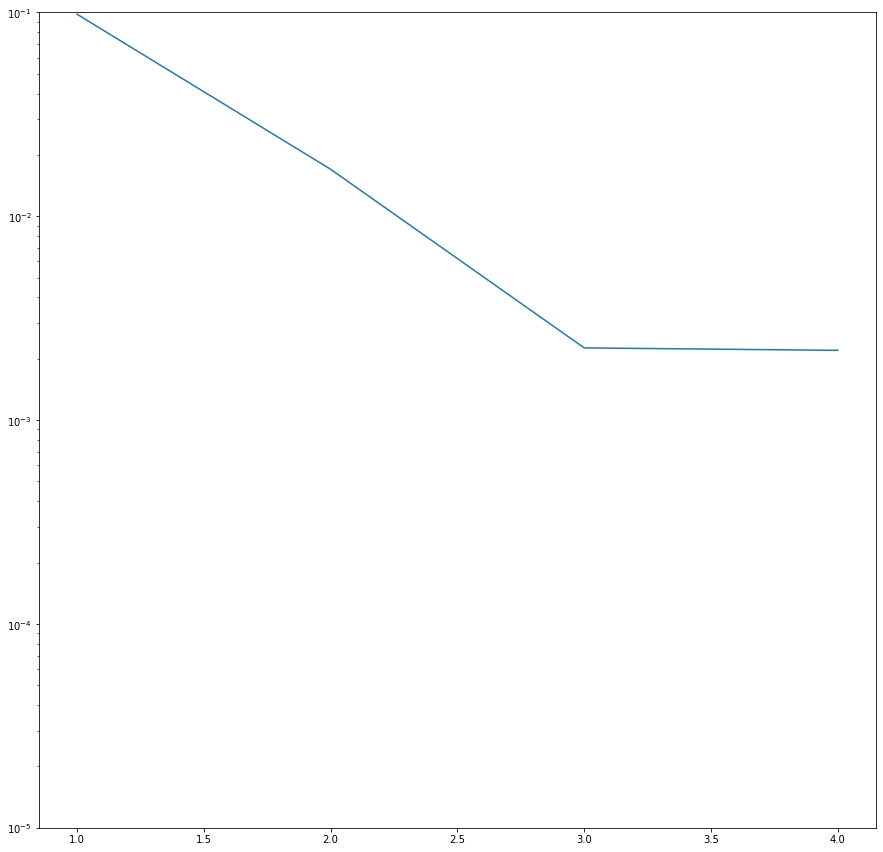

In [41]:
# to quantify the effect of each paramter, we compare the correlation function with the each paramter se to 0 independently
ind_deformation = -1
errors = []

for ind_q, _ in enumerate(n_coeffs_fit[ind_deformation]):
    gammas = np.copy(n_coeffs_fit[ind_deformation])
    C1 =  Compute_correlation(gammas, qs) 
    gammas[ind_q] = 0
    C2 =  Compute_correlation(gammas, qs)
    errors.append(np.mean(np.abs(C1-C2)**2))

plt.figure(figsize = (15,15))
plt.semilogy(qs,errors)
plt.ylim([1e-5,1e-1])
errors




### C.3 Show the results

#### RME Correlation

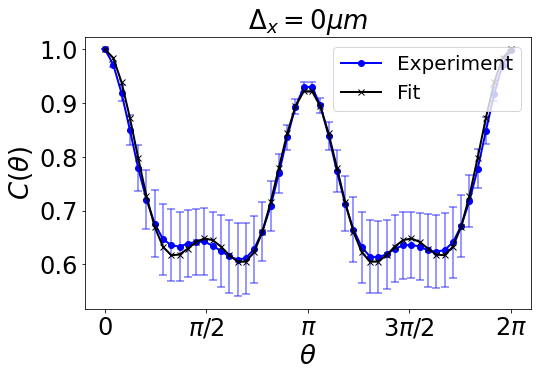

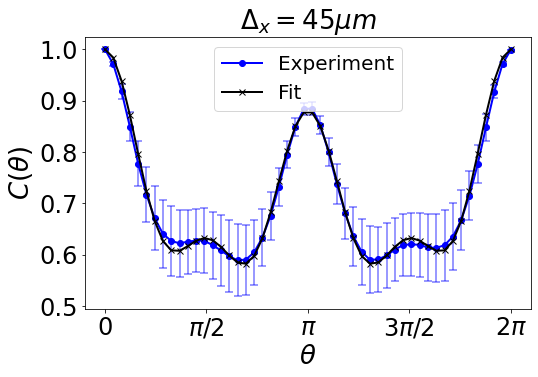

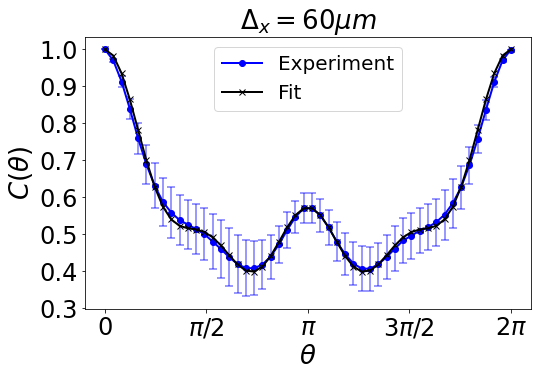

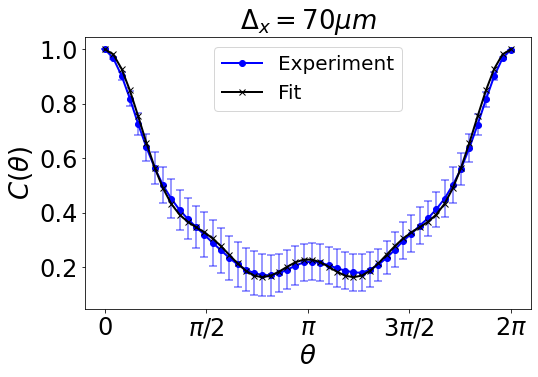

In [42]:
initial_guess

def show_RME_corr(show_error=True, save_fig=True):
    deformations2show = [0, 2, 3, 4]
    # deformations2show = [0, 1]

    # plt.subplot(211)
    for ind_deformation in deformations2show:
        plt.figure(figsize=(8, 5))
        plt.errorbar(
            angles,
            Corr_mean_exp[ind_deformation],
            label=rf"Experiment",
            color="blue",
            marker="o",
            linewidth=2,
        )
        if show_error:
            plot_error(
                Corr_mean_exp[ind_deformation],
                Corr_std_exp[ind_deformation],
                color="blue",
            )

        plt.errorbar(
            angles,
            Corr_theory[ind_deformation],
            label=rf"Fit",
            color="black",
            marker="x",
            linewidth=2,
        )

        # plt.errorbar(
        #     angles,
        #     Corr_approx_small_angles[ind_deformation],
        #     label=rf"Approx small angles",
        #     color="green",
        #     marker="d",
        #     linewidth=2,
        # )

        

        plt.xlabel(r"$\theta$", fontsize=LABEL_SIZE)
        plt.ylabel(r"$C(\theta)$", fontsize=LABEL_SIZE)
        xticks = [0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi]
        xtics_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]
        plt.xticks(xticks, xtics_labels, fontsize=TICK_SIZE)
        plt.yticks(fontsize=TICK_SIZE)
        plt.legend(fontsize=LEGEND_SIZE)
        plt.title(rf"$\Delta_x={Delta_x[ind_deformation]:.0f}\mu m$", fontsize=TITLE_SIZE)

    if save_fig:
        plt.savefig(
            image_path(f"RME_exp_Vs_theory.svg"),
            dpi=300,
        )


# G = [0, .032, 0.165,0,0.07 ]
show_RME_corr(show_error=True, save_fig=SAVE_FIG)

In [43]:
n_coeffs_fit

array([[0.19234621, 0.45360734, 0.10892968, 0.34790148],
       [0.20489152, 0.45374617, 0.1164836 , 0.3486925 ],
       [0.25065485, 0.45449061, 0.13147685, 0.34802136],
       [0.54382709, 0.48327951, 0.23316296, 0.36104605],
       [0.86051905, 0.57906742, 0.37399052, 0.38352643]])

#### Evolution of the fit parameters
Only show significant paramters

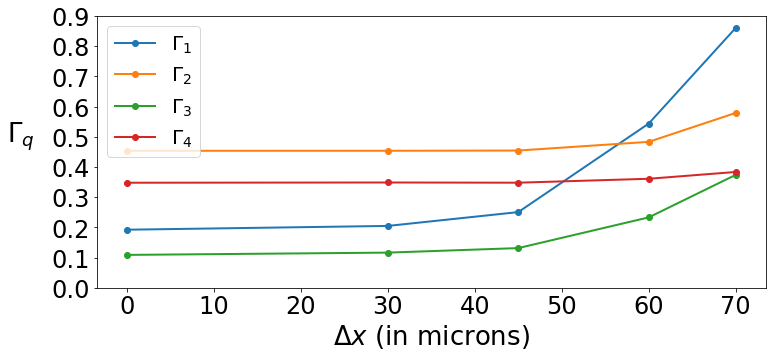

In [44]:
# Delta_n_coeffs_fit = n_coeffs_fit-n_coeffs_fit[0]
plt.figure(figsize = (12,5))
for ind_q, q in enumerate(qs):
    plt.plot(
        Delta_x, 
        n_coeffs_fit[:,ind_q], 
        marker = 'o',
        label = rf'$\Gamma_{q}$',
        linewidth = 2,
    )
plt.legend()
plt.ylabel(r'$\Gamma_q$', fontsize=LABEL_SIZE, labelpad=30, rotation=0)
plt.xlabel(r"$\Delta x$ (in microns)", fontsize=LABEL_SIZE)
plt.xticks(fontsize=TICK_SIZE)
plt.yticks(fontsize=TICK_SIZE)
plt.legend(fontsize=LEGEND_SIZE, loc = 'upper left')
plt.ylim([0.,0.9])

if SAVE_FIG:
    plt.savefig(
        image_path(f"Gamma_q.svg"),
        dpi=300,
    )
# plt.ylim([0,10])

#### Decomposition in the different contributions

# IV. Simulations
**Compare segment model to experiment for no bending**

In [45]:
# L_tot = 2.45e4 # total length 10cm
# dz = 2e2 #um
# # correlation length in the z direction 100 umn
# d_layer = 1e-3
# f_n = profile.radialFunc
# n_coeffs = [0,1]

# dr = 5*dh
# dr = d_layer#5 * dh

n_r = 2**9
n_th = 2**5

r_max = modes.data[0]['r_max']

R, TH = np.meshgrid(
    np.linspace(0, r_max, n_r), np.linspace(0, 2 * np.pi, n_th, endpoint=False)
)

dR = areaSize / (2*(n_r-1))
dTH = 2*np.pi/n_th

Mrth = np.array(
    [
        modes.data[i]["radial_func"](R.ravel())
        # / norms_fr[i]
        * np.exp(1j * m[i] * TH.ravel())
        for i in range(nmodes)
    ]
).transpose()

norms_Mrth = np.sqrt(np.sum(np.abs(Mrth).transpose()**2*R.ravel(), axis = 1))#np.linalg.norm(Mrth.transpose()*R.ravel(), axis = 1)
Mrth = Mrth / norms_Mrth




def getTM_seg(d_layer, f_n, dz, n_coeffs, qs, l_corr=None):
    """
    Compute the TM of a segment of fiber of length `d_z`
    Paremeters
    ----------
    d_layer : float
        Thickness of the layers in microns
    f_n : function
        Function that returns the refractive index of the fiber for a given radial position
    dz : float
        Length of the segment
    n_coeffs : int
        Number of coefficients to use in the expansion of azimuthal disorder function
    qs : array
        Array of the q values (orbital angular momenta) corresponding to each n_ceoffs.
        Should be the same size as n_coeffs.
    beta_f_type : str ['sinc', 'gauss']
        Type of function to use in the longitudinal autocrrelation function
    l_corr : float
        Correlation length of the longitudinal disorder function in microns

    Returns
    -------
    data : dict
        Dictionary with parameters of the disordered segment
    TM : ndarray
        Transmission matrix of the disordered segment
    """

    assert(len(n_coeffs) == len(qs))

    betas = np.array(modes.betas).astype(np.float32)

    ## Radial disorder ##
    ## --------------- ##
    # random steps of size d_layer and of amplitude in delta_n = dn0/dr * d_layer
    r_max = 3 * areaSize

    r_vec = np.arange(0, r_max, d_layer)

    

    # values of the index over a range of radii
    n = np.array([f_n(r) for r in r_vec])
    # differentiate n
    dn = np.diff(n)
    # noise variance proprtional to the difference of indexes between two layers
    noise_std = dn / d_layer * d_layer
    # print(f"noise variance = {np.max(np.abs(noise_variance)):.2e}")
    
    gaussian_noise = np.random.randn(*noise_std.shape)

    # varation of the index between the index of two consecutives layers
    noise = gaussian_noise * noise_std

    # interpolate radial noise as a fonction
    f_noise = interp1d(
        (r_vec[:-1]+r_vec[1:])/2, 
        noise, 
        kind="nearest",
        bounds_error=False,
        fill_value="extrapolate"
        )

    # get the profile of delta_n over the mesh
    delta_n = np.fromiter((f_noise(r) for r in np.abs(R.flatten())), np.float32)

    ## Azimuthal disorder ##
    ## ------------------ ##
    azimuthal_components = []
    for q_val, c in zip(qs, n_coeffs):
        phi0 = np.random.rand() * 2 * np.pi if q_val != 0 else 0
        azimuthal_components.append(
             c * np.cos(q_val * TH.flatten() + phi0)
        )
    azimuthal_components = np.array(azimuthal_components).astype(np.complex64)
    
    # sum the contributions
    sum_azimuthal_components = np.sum(azimuthal_components, axis=0)

    ## Total perturbation ##
    ## ------------------ ##

    # final transverse disorder function = radial x azimuthal
    delta_n = delta_n * sum_azimuthal_components

    ## TM in the mode basis ##
    ## -------------------- ##

    # project of the disorder in the mode basis
    # delta_n_modes = M.transpose().conjugate()@np.diag(delta_n)@M
    # equivalent to M.transpose().conjugate()@np.diag(delta_n)@M but less memory greedy
    # + in the radial coordinate (hence the R**2)
    delta_n_modes = np.einsum('kj,k,km,k->jm', Mrth.conjugate(), delta_n, Mrth, R.ravel())
                                                                                        
    V = k0*delta_n_modes

    H0 = np.diag(betas)

    TM = expm(- 1j * (H0 + V) * dz)

    # save some shit
    data = {
        "delta_n": delta_n,
        "H0": H0,
        "V": V,
        "k0": k0,
        "dz": dz,
        "f_noise": f_noise,
        "noise": noise,
        "gaussian_noise": gaussian_noise,
        "noise_std": noise_std,
        "dn": dn
    }

    return data, TM

## General parameters

Parameters from Lille:
* Variations d'indice sur $\Delta r$ ~ epaisseur de couche ~ 2 nm (??)
* Largeur autocorrelation désordre en $z \approx$ 0.1 mm (to 1mm ??)

## Segments model

we add randomness to the segment size to mitigate beating effects

In [46]:
n_coeffs_fit

array([[0.19234621, 0.45360734, 0.10892968, 0.34790148],
       [0.20489152, 0.45374617, 0.1164836 , 0.3486925 ],
       [0.25065485, 0.45449061, 0.13147685, 0.34802136],
       [0.54382709, 0.48327951, 0.23316296, 0.36104605],
       [0.86051905, 0.57906742, 0.37399052, 0.38352643]])

In [47]:

# n_coeffs_fit = n_coeffs_fit_old[[0,2,3]]*0.75

In [48]:
Corr_theory = np.stack([Compute_correlation(gammas, qs) for gammas in n_coeffs_fit], axis = 0)

In [49]:
from tqdm import tqdm

# number of different realizations of the disorder
n_ave = 20
# number of random input wavefront for each realization
n_rnd_input = 100

bkp_data = []

# number of uncorrelated segments
n_segments = int(np.round(L_tot / dz))

def getTM_all(n_coeffs, qs, d_layer, dz, L_tot):
    TM_tot = np.eye(nmodes, dtype=complex)

    data_all = []
    for _ in tqdm(range(n_segments)):
        data, TM = getTM_seg(
            d_layer=d_layer,
            f_n=profile.radialFunc,
            dz=dz+ (0.5 - np.random.rand()) * wl * 2,
            n_coeffs=n_coeffs,
            qs = qs,
        )
        data_all.append(data)
        data_all[-1]["TM_seg"] = TM
        TM_tot = TM @ TM_tot

    return data_all, TM_tot.astype(np.complex64)



TM_seg_all = []

# ind_temp = [0,3]

for ind_deformation, nvec in enumerate(n_coeffs_fit):
    print(f'{ind_deformation+1}/{len(deformation_indices)}')
    TM_seg_all.append([])
    for _ in range(n_ave):
        data_all, TM_seg = getTM_all(nvec, qs, d_layer, dz, L_tot)
        TM_seg_all[-1].append(TM_seg)
        bkp_data.append(
            {
                "nvec": nvec,
                "data_all": data_all,
                "TM": TM_seg,
                "L_tot": L_tot,
                "dz": dz,
                "d_layer": d_layer,
            }
        )
TM_seg_all = np.array(TM_seg_all)

  0%|          | 0/245 [00:00<?, ?it/s]

1/5


  0%|          | 0/245 [00:00<?, ?it/s]

2/5


  0%|          | 0/245 [00:00<?, ?it/s]

3/5


  0%|          | 0/245 [00:00<?, ?it/s]

4/5


  0%|          | 0/245 [00:00<?, ?it/s]

5/5


 78%|███████▊  | 191/245 [02:15<00:37,  1.45it/s]

In [ ]:
# TM_seg_all = np.array(TM_seg_all)

## Compute RME Correlation

We average over realizations disorder + random inputs

In [ ]:
data2save['simu'] = {}
data2save['simu']['param'] = {
    'n_ave': n_ave,
    'n_rnd_input': n_rnd_input,
    'L_tot' : L_tot,
    'dz' : dz,
    'd_layer' : d_layer,
    'dr' : dr,
    'gammas' : n_coeffs_fit,
}

data2save['simu']['data'] = bkp_data
data2save['simu']['TMs'] = TM_seg_all
save_data()

In [ ]:
# TMs = TM_seg_all[0,...]

# compute the rotation operators for all the rotation angles
R_mats = np.array([get_rotation_matrix(m, l, angle) for angle in angles])

# operator rotation \theta -> TM -> rotation -\theta
Ttheta = np.einsum('aim,drmn,anj->draij', R_mats, TM_seg_all, R_mats.conjugate()) 

# random input in the mode basis
E_rnd_in_mode = (np.random.rand(n_rnd_input, n_modes)-0.5)+1j*(np.random.rand(n_rnd_input, n_modes)-0.5)

# apply to random input fields
Y_seg = np.einsum('draij,oj->dorai', Ttheta, E_rnd_in_mode)



In [ ]:
Y_seg_ref = Y_seg[...,0,:]
Corr_seg = stack_correlation(Y_seg, Y_seg_ref)
# note that the correlation are computed in the mode basis
# yield the same results as in the pixel basis
# but is less memory and ressource consuming

# Corr_seg = []
# for Y in Y_seg:
#     Y_ref = Y[...,0,:]
#     Corr_seg.append(stack_correlation(Y, Y_ref))
# Corr_seg = np.array(Corr_seg)

In [ ]:
Corr_seg_mean = np.mean(Corr_seg, axis = (1,2))
Corr_seg_std = np.std(Corr_seg, axis = (1,2))

data2save['simu'] = {}
data2save['simu']['Corr_mean'] = Corr_seg_mean
data2save['simu']['Corr_std'] = Corr_seg_std
save_data()

array([[0.19977546, 0.45660513, 0.35275748],
       [0.21281251, 0.4571768 , 0.35424471],
       [0.2588637 , 0.45879643, 0.35511547],
       [0.5541366 , 0.49578806, 0.38196303],
       [0.8724529 , 0.60366681, 0.43144357]])

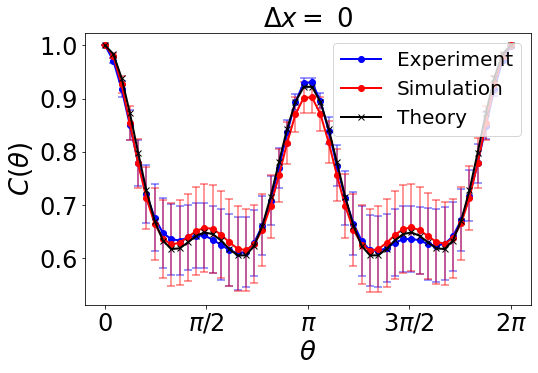

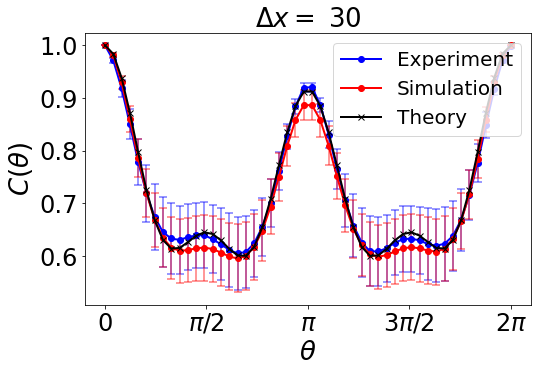

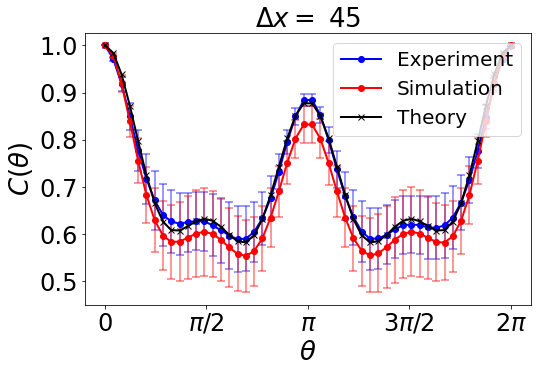

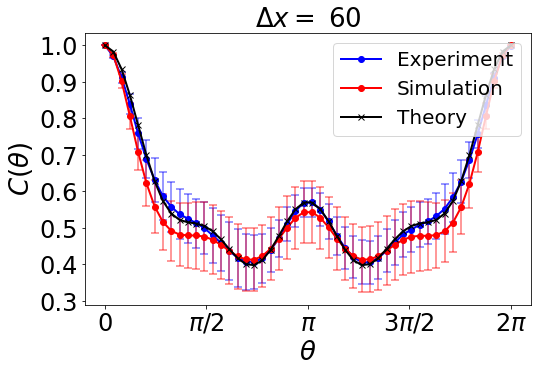

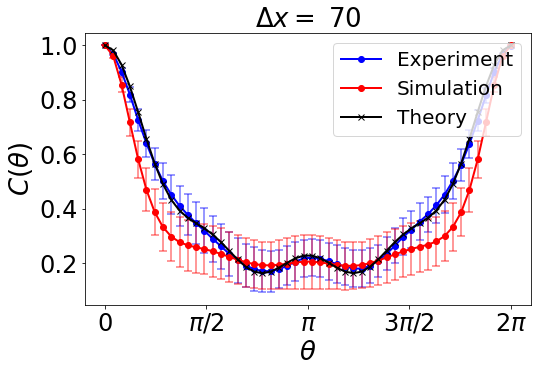

In [ ]:


%matplotlib inline

def show_RME_corr( show_error=True, ind_deformation = 0, save_fig = True):
    # deformations2show = [0,2,3,4]
    plt.figure(figsize=FIGSIZE)

    for ind_deformation in [ind_deformation]:
        plt.errorbar(
            angles, 
            Corr_mean_exp[ind_deformation], 
            label=rf'Experiment',
            color = 'blue',
            marker='o',
            linewidth=2,
        )
        if show_error:
            plot_error(
                Corr_mean_exp[ind_deformation], 
                Corr_std_exp[ind_deformation], 
                color = 'blue')

    
    plt.errorbar(
        angles, 
        Corr_seg_mean[ind_deformation], 
        label=rf'Simulation',
        color = 'red',
        marker='o',
        linewidth=2,
    )


    if show_error:
        plot_error(
            Corr_seg_mean[ind_deformation], 
            Corr_seg_std[ind_deformation], 
            color = 'red')

    
    plt.errorbar(
        angles, 
        Corr_theory[ind_deformation], 
        label=rf'Theory',
        color = 'black',
        marker='x',
        linewidth=2
    )


    

    plt.xlabel(r"$\theta$", fontsize=LABEL_SIZE)
    plt.ylabel(r"$C(\theta)$", fontsize=LABEL_SIZE)
    xticks = [0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi]
    xtics_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]
    plt.xticks(xticks, xtics_labels, fontsize=TICK_SIZE)
    # plt.ylim([0.3, 1.05])
    plt.yticks(fontsize=TICK_SIZE)
    plt.legend(fontsize=LEGEND_SIZE, loc = 'upper right')
    plt.title(fr'$\Delta x =$ {Delta_x[ind_deformation]:.0f}', fontsize = TITLE_SIZE)

    if save_fig:
        plt.savefig(
            image_path(f"RME_exp_Vs_simu_Dx_{Delta_x[ind_deformation]:.0f}.svg"),
            dpi=300,
        )


for ind_deformation in range(len(deformation_indices)):
    show_RME_corr( show_error=True, ind_deformation = ind_deformation, save_fig = True)




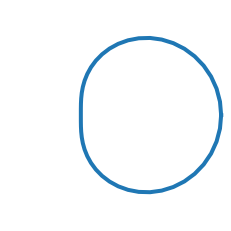

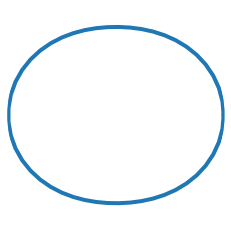

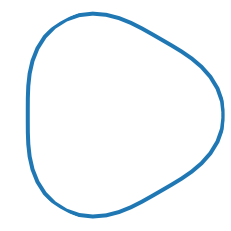

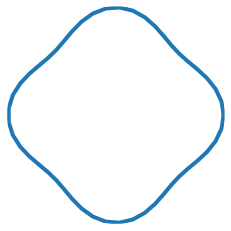

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
qs = (1,2,3,4)

# Generate angle values
theta = np.linspace(0, 2 * np.pi, 50)

a = 1  

for ind_q, q in enumerate(qs):
    b = .1 if q>1 else 0.5 # Semi-minor axis
    plt.figure()
    # Create polar plot
    radius = a+ b * np.cos(q*theta)
    plt.polar(theta, radius, linewidth = 4)

    # Remove axis and ticks
    plt.axis('off')

    # Save figure
    if SAVE_FIG:
        plt.savefig(
            image_path(f'deform_q_{ind_q}.svg'),
            dpi=300, 
            bbox_inches='tight'
        )


# Effect of bending

## Compute Hamiltonians for different bend values

In [ ]:
l_bend = 1e3 #1mm
bends = 10**np.linspace(5.35, 3.5, 9)
# Hs_bends = []

# for bend in tqdm(bends):
#     Hs_bends.append(modes.getEvolutionOperator(curvature = (1e6,bend)))

In [ ]:
Ts_bend = []
for bend in tqdm(bends):
    Ts_bend.append(modes.getPropagationMatrix(distance = 1e3, curvature = (1e6,bend)))

  0%|          | 0/9 [00:05<?, ?it/s]


MemoryError: Unable to allocate 64.0 GiB for an array with shape (65536, 65536) and data type complex128

In [ ]:
plt.figure()
plt.imshow(np.abs(Ts_bend[-1]))

## Compute RME for bending alone

In [ ]:
C_bend_all = []
C_I_bend_all = []
for TM in Ts_bend:
    C, C_I = get_RME(TM, n_ave, angles)
    C_bend_all.append(C)
    C_I_bend_all.append(C_I)

C_bend_all = np.array(C_bend_all) 
C_I_bend_all = np.array(C_I_bend_all) 

## Show RME Correlation

In [ ]:
%matplotlib notebook

Cs = np.array(C_bend_all[::-1])#.transpose()


plt.figure(figsize = (12,6))
# plt.title('Without correction')

# Exp data
cmap = get_color_map(n = len(Cs))
for i, C in enumerate(Cs):
    plt.plot(angles/np.pi, C, color = cmap(i))

# for i, C in enumerate(C_model_all):
#     plt.plot(angles/np.pi, C, "b--", alpha = .35)

# for i, C in enumerate(C_model_all):
#     plt.plot(angles/np.pi, C, "b--", alpha = .35)
    
# C_model_mean = C_model_all.mean(axis = 0)
# plt.plot(angles/np.pi, C_model_mean, "bx-")
    
    
plt.xticks([0,0.5,1], [r'$0$', r'$\pi/2$', r'$\pi$'], fontsize = 16)
plt.yticks(fontsize=16)
plt.grid()
plt.ylim([0,1.05])

# Bending + disorder 
**Bending in the middle of the fiber**

## Product matrices

In [ ]:
import random

C_prod_all = []
C_I_prod_all = []
for TM_bend in Ts_bend:
    C_prod_all.append([])
    C_I_prod_all.append([])
    for TM_rnd in TM_seg_all:
        TM_bend2 = random.choice(TM_seg_all)
        T_tot = TM_bend@TM_rnd#@TM_bend2
        C, C_I = get_RME(T_tot, n_ave, angles)
        C_prod_all[-1].append(C)
        C_I_prod_all[-1].append(C_I)
        
C_prod_all = np.array(C_prod_all)
C_I_prod_all = np.array(C_I_prod_all)

In [ ]:
C_prod_ave = np.mean(C_prod_all, axis = 1)
C_I_prod_ave = np.mean(C_I_prod_all, axis = 1)

### Field correlation

#### Product of correlation VS Correlation of product

In [ ]:
%matplotlib notebook

Cprod = np.array(C_prod_ave[::-1])#.transpose()
Cs = np.array(C_all[1:][:5:-1])#.transpose()
Cprod_X = np.array(C_bend_all[::-1])#.transpose()

plt.figure(figsize = (12,6))
cmap = get_color_map(n = len(Cprod))
for i, C in enumerate(Cprod):
    plt.plot(angles/np.pi, C, color = cmap(i))
    
cmap = get_color_map2(n = len(Cs))
for i, C in enumerate(Cprod_X):
    plt.plot(angles/np.pi, C*C_model_mean, color = cmap(i))

# for i, C in enumerate(Cs):
#     plt.plot(angles/np.pi, C, color = cmap(i), linestyle = "--", label = f'c={ns[::-1][i]}')

    
plt.xticks([0,0.5,1], [r'$0$', r'$\pi/2$', r'$\pi$'], fontsize = 16)
plt.yticks(fontsize=16)
plt.grid()
plt.ylim([0,1.05])

### Intensity correlation

In [ ]:
%matplotlib notebook

Cprod = np.array(C_I_prod_ave[-3::-1])#.transpose()
Cs = np.array(C_I_all[1:][:5:-3])#.transpose()

plt.figure(figsize = (12,6))
cmap = get_color_map(n = len(Cprod))
for i, C in enumerate(Cprod):
    plt.plot(angles/np.pi, C, color = cmap(i))
    
cmap = get_color_map2(n = len(Cs))
for i, C in enumerate(Cs):
    plt.plot(angles/np.pi, C, color = cmap(i), linestyle = "--", label = f'c={ns[::-1][i]}')

    
plt.xticks([0,0.5,1], [r'$0$', r'$\pi/2$', r'$\pi$'], fontsize = 16)
plt.yticks(fontsize=16)
plt.grid()
plt.ylim([0,1.05])

In [ ]:
# C_sum = C_rnd
# C_0 = C_rnd
# C_2 = C_rnd
# T_2 = TM_tot

In [ ]:
plt.figure()
plt.plot(angles/np.pi, C_0, label = 'n=0')
plt.plot(angles/np.pi, C_2, 'kx', label = 'n=2')
plt.plot(angles/np.pi, C_tot, 'g', label = 'sum')
plt.plot(angles/np.pi, C_0*C_2, 'gx', label = r'$C_0 \times C_2$')
plt.xticks([0,0.25,.5,.75,1.], [r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'], fontsize = 16)
plt.yticks(fontsize=16)
plt.grid()
plt.ylim([0.6,1.05])
plt.ylabel(r'$C(\theta)$')
plt.xlabel(r'$\theta$ (radian)')
plt.legend()

In [ ]:
plt.figure()
plt.plot(angles/np.pi, C_rnd)
plt.xticks([0,0.25,.5,.75,1.], [r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'], fontsize = 16)
plt.yticks(fontsize=16)
plt.grid()
plt.ylim([0.6,1.05])
plt.ylabel(r'$C(\theta)$')
plt.xlabel(r'$\theta$ (radian)')

In [ ]:
plt.figure()
plt.plot(angles, C_rnd)

In [ ]:
plt.figure()
plt.plot(angles, C_rnd)

In [ ]:
# theta = np.arcsin(0.15)
# # theta = 0
# n2 = 1.45
# n1 = 1
# np.abs((n1*np.cos(theta)-n2*np.sqrt(1-(n1/n2*np.sin(theta))))/(n1*np.cos(theta)+n2*np.sqrt(1-(n1/n2*np.sin(theta)))))**2

## Add effect of irregular section

In [ ]:
%matplotlib inline
lc = 5e4
coeff = 1#5e-8

T_rnd = np.random.randn(nmodes, nmodes)+1j*np.random.randn(nmodes, nmodes)
# TM_rnd = np.exp(1j*np.random.randn(nmodes, nmodes)*2*np.pi)
# mask_ballistic = np.eye(nmodes, nmodes)
# mask_beta = 1/(deltaBeta**2+7.5e-6)
mask_beta = 1/(lc*(deltaBeta**2+1/lc**2))
# mask_beta = mask_beta/np.max(mask_beta)
mask_m = np.abs(deltaM) == 2
# coeff = 0.23

T_model = T_rnd*coeff*mask_beta*mask_m#+Hs_bends[0]
# H_model = H_model + H_model.transpose()

plt.figure()
plt.imshow(np.abs(T_model))
plt.figure()
plt.imshow(sort(np.abs(T_model)))

In [ ]:
# TM_rnd = np.random.randn(nmodes, nmodes)+1j*np.random.randn(nmodes, nmodes)
# # TM_rnd = np.exp(1j*np.random.randn(nmodes, nmodes)*2*np.pi)
# mask_ballistic = np.eye(nmodes, nmodes)
# mask_beta = 1/(deltaBeta**2+7.5e-6)
# mask_beta = mask_beta/np.max(mask_beta)
# mask_m = np.abs(deltaM) == 2
# coeff = 0.23

# TM_model = mask_ballistic+TM_rnd*coeff*mask_beta*mask_m

# plt.figure()
# plt.imshow(np.abs(TM_model))
# plt.figure()
# plt.imshow(sort(np.abs(TM_model)))

## 1.5 Width of rotational ME

### 1.5.1 Compute Correlation curves for the different bend values

In [ ]:
ind = 0

L = 100
n_ave = 25
n_angles = 31
angles = np.linspace(0, np.pi, n_angles)

C_rnd = []
C_all_simu_bend = []

for T_bend in tqdm(Ts_bend):
    C_rnd = []
    for angle in angles:
        R_mat = get_rotation_matrix(m, l, angle)
        C_temp = []
        
#         H_tot = H_bend+H_model
#         TM = expm(1j*H_bend*L)@expm(1j*H_model*L)
#         TM = expm(1j*H_tot*L)
#         TM = 1j*H_model*L+np.eye(H_model.shape[0])
#         TM = TM_model
        TM = T_bend#@T_2
        for _ in range(n_ave):
            vec_in_rnd = (np.random.rand(len(m))-0.5)+1j*(np.random.rand(len(m))-0.5)
            
            E1_rnd = M@R_mat@TM@vec_in_rnd
            E2_rnd = M@TM@R_mat@vec_in_rnd
            I1_rnd = np.abs(E1_rnd)**2
            I2_rnd = np.abs(E2_rnd)**2
            
            C_temp.append(corr(E1_rnd,E2_rnd))


        C_rnd.append(np.mean(C_temp))
    C_all_simu_bend.append(C_rnd)

In [ ]:
# C_all_simu_bend_sum = C_all_simu_bend

In [ ]:
%matplotlib inline

Cs0 = np.abs(np.array(C_all_simu_bend))[::-1]#.transpose()
Cs = np.abs(np.array(C_all_simu_bend_sum))[::-1]#.transpose()

plt.figure(figsize = (8,4))
# plt.title('Without correction')

cmap = get_color_map(n = len(Cs))
for i, C in enumerate(Cs):
    plt.plot(angles/np.pi, C, color = cmap(i))
plt.plot(angles/np.pi, C_2, 'bx')
for i, C in enumerate(Cs0):
    plt.plot(angles/np.pi, (C*C_2), color = cmap(i), linestyle = '--')
plt.xticks([0,0.25,.5,.75,1.], [r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'], fontsize = 16)
plt.yticks(fontsize=16)
plt.grid()
plt.ylim([0.,1.05])
plt.ylabel(r'$C(\theta)$')
plt.xlabel(r'$\theta$ (radian)')

In [ ]:
%matplotlib inline

Cs = np.abs(np.array(C_all_simu_bend))[::-1]#.transpose()

plt.figure(figsize = (8,4))
# plt.title('Without correction')

cmap = get_color_map(n = len(Cs))
for i, C in enumerate(Cs):
    plt.plot(angles/np.pi, C, color = cmap(i))
plt.xticks([0,0.25,.5,.75,1.], [r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'], fontsize = 16)
plt.yticks(fontsize=16)
plt.grid()
plt.ylim([0,1.05])
plt.ylabel(r'$C(\theta)$')
plt.xlabel(r'$\theta$ (radian)')

In [ ]:
len(C_2)

# 2. Experimental measurements

# 2.1 Load measured TMs

In [ ]:
TMs = np.load('TMs_mod_corrected.npy')
nmodes = TMs.shape[-1]
TMs_pola1 = TMs[:,:nmodes, :]
TMs_pola2 = TMs[:,nmodes:, :]

## 2.3 Width of rotational ME

### 2.3.1 Compute Correlation curves for the different deformations

In [ ]:
### 2.3.1 Compute Correlation curves for the different deformations
ind = 0

TM = TMs_pola1[ind]
n_ave = 20
n_angles = 15
angles = np.linspace(0, np.pi, n_angles)

C_rnd = []
C_all = []




for TM in tqdm(TMs_pola1):
    C_rnd = []
    for angle in angles:
        R_mat = get_rotation_matrix(m, l, angle)
        C_temp = []
        for _ in range(n_ave):
            vec_in_rnd = (np.random.rand(len(m))-0.5)+1j*(np.random.rand(len(m))-0.5)
            

            E1_rnd = M@R_mat@TM@vec_in_rnd
            E2_rnd = M@TM@R_mat@vec_in_rnd
            I1_rnd = np.abs(E1_rnd)**2
            I2_rnd = np.abs(E2_rnd)**2
            
            C_temp.append(np.abs(corr(E1_rnd,E2_rnd)))

            # C_temp.append(corr(I1_rnd,I2_rnd))

        C_rnd.append(np.mean(C_temp))
    C_all.append(C_rnd)


    

In [ ]:
C_all = np.array(C_all)

In [ ]:
x0 = np.pi
y0 = C_all[0][angles == np.pi][0]

sigma_corr = x0/np.sqrt(-2*np.log(y0))

def gauss(x,sigma):
    return np.exp(-(x)**2/(2*sigma**2))
    
correction_decorr_0 = gauss(angles,sigma_corr)

In [ ]:
%matplotlib inline

Cs = C_all[1:][::-1]#.transpose()

plt.figure(figsize = (6,13))
plt.subplot(311)
# plt.title('Without correction')

cmap = get_color_map(n = len(Cs))
for i, C in enumerate(Cs):
    plt.plot(angles/np.pi, C, color = cmap(i))
plt.xticks([0,0.5,1], [r'$0$', r'$\pi/2$', r'$\pi$'], fontsize = 16)
plt.yticks(fontsize=16)
plt.grid()
plt.ylim([0,1.05])
# plt.plot(angles/np.pi,(C_all[12:]).transpose())
# plt.plot(angles/np.pi, correction_decorr_0, 'b-')
plt.subplot(312)
plt.title('Remove revival dip')
for i, C in enumerate(Cs):
    plt.plot(angles/np.pi, C/C_all[0], color = cmap(i))
plt.xticks([0,0.5,1], [r'$0$', r'$\pi/2$', r'$\pi$'], fontsize = 16)
plt.yticks(fontsize=16)
plt.grid()
plt.ylim([0,1.05])
# plt.plot(angles/np.pi, C_all[-1]/C_all[0], label = 'random input mean', color = 'red')
# plt.plot(angles/np.pi,(C_all[12:]/C_all[0]).transpose());
plt.subplot(313)
plt.title('Remove revival dip')
for i, C in enumerate(Cs):
    plt.plot(angles/np.pi, correction_decorr_0*C/C_all[0], color = cmap(i))
plt.xticks([0,0.5,1], [r'$0$', r'$\pi/2$', r'$\pi$'], fontsize = 16)
plt.yticks(fontsize=16)
plt.grid()
plt.ylim([0,1.05])
# plt.plot(angles/np.pi, C_all[-1]/C_all[0], label = 'random input mean', color = 'red')
# plt.plot(angles/np.pi,(correction_decorr_0*C_all[12:]/C_all[0]).transpose());

In [ ]:
plt.figure(figsize = (8,8))
# plt.title('Without correction')

plt.subplot(211)
Cs = np.abs(np.array(C_all_simu_bend))[::-1]
cmap = get_color_map(n = len(Cs))
for i, C in enumerate(Cs):
    plt.plot(angles/np.pi, C, color = cmap(i))
plt.xticks([0,0.25,.5,.75,1.], [r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'], fontsize = 16)
plt.yticks(fontsize=16)
plt.grid()
plt.ylim([0,1.05])
plt.ylabel(r'$C(\theta)$')
plt.xlabel(r'$\theta$ (radian)')

# plt.title('Without correction')

plt.subplot(212)
Cs = C_all[1:][::-1]
cmap = get_color_map(n = len(Cs))
for i, C in enumerate(Cs):
    plt.plot(angles/np.pi, C, color = cmap(i))
plt.xticks([0,0.25,.5,.75,1.], [r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'], fontsize = 16)
plt.yticks(fontsize=16)
plt.grid()
plt.ylim([0,1.05])
plt.ylabel(r'$C(\theta)$')
plt.xlabel(r'$\theta$ (radian)')

### Model for revival

In [ ]:
C_revival_exp = C_all[0]/correction_decorr_0

In [ ]:
TM_rnd = np.random.randn(nmodes, nmodes)+1j*np.random.randn(nmodes, nmodes)
# TM_rnd = np.exp(1j*np.random.randn(nmodes, nmodes)*2*np.pi)
mask_ballistic = np.eye(nmodes, nmodes)
mask_beta = 1/(deltaBeta**2+7.5e-6)
mask_beta = mask_beta/np.max(mask_beta)
mask_m = np.abs(deltaM) == 2
coeff = 0.23

TM_model = mask_ballistic+TM_rnd*coeff*mask_beta*mask_m

plt.figure()
plt.imshow(np.abs(TM_model))
plt.figure()
plt.imshow(sort(np.abs(TM_model)))

In [ ]:
TM_model.shape

In [ ]:
C_model_TM = []

TM_model_with_bend = TM_model@TMs_bends[1]

for angle in tqdm(angles):
    R_mat = get_rotation_matrix(m, l, angle)
    C_temp = []
    for _ in range(n_ave):
        vec_in_rnd = (np.random.rand(len(m))-0.5)+1j*(np.random.rand(len(m))-0.5)
        
        I1_rnd = np.abs(M@R_mat@TM_model_with_bend@vec_in_rnd)**2
        I2_rnd = np.abs(M@TM_model_with_bend@R_mat@vec_in_rnd)**2
        C_temp.append(corr(I1_rnd,I2_rnd))

    C_model_TM.append(np.mean(C_temp))

In [ ]:
ymin = 0.6
ymax = 1.01

plt.figure(figsize = (12,3.25))
plt.subplot(131)
plt.plot(angles/np.pi, C_all[0], 'b-')
plt.xticks([0,0.5,1], [r'$0$', r'$\pi/2$', r'$\pi$'], fontsize = 16)
plt.plot(angles/np.pi, C_model_TM, 'g--')
plt.yticks(fontsize=16)
plt.grid()
plt.ylim([ymin,ymax])
plt.subplot(132)
plt.plot(angles/np.pi, correction_decorr_0, 'b-')
plt.xticks([0,0.5,1], [r'$0$', r'$\pi/2$', r'$\pi$'], fontsize = 16)
plt.yticks(fontsize=16)
plt.grid()
plt.ylim([ymin,ymax])
plt.subplot(133)
plt.plot(angles/np.pi, C_revival_exp, 'b-')
plt.plot(angles/np.pi, C_model_TM, 'g--')
plt.xticks([0,0.5,1], [r'$0$', r'$\pi/2$', r'$\pi$'], fontsize = 16)
plt.yticks(fontsize=16)
plt.grid()
plt.ylim([ymin,ymax])
plt.tight_layout(pad=2.0)

### 2.3.2 Width with Gaussian fit

Fit only the upper part of the correlation function ($C>0.8$)

In [ ]:
from scipy.optimize import curve_fit

def gauss(x,sigma):
    return np.exp(-(x)**2/(2*sigma**2))


widths_gauss = []
ipr_RME = []
for C in C_all:
    
    C = correction_decorr_0*np.array(C)/C_all[0]

    mask = C > 0.5

    sigma = np.sum(C*angles**2)/len(C)
    popt,pcov = curve_fit(gauss, angles[mask], C[mask], p0=[sigma])
    widths_gauss.append(popt[0])

    
    ipr_RME.append(np.sum(np.abs(C)**2)/np.sum(np.abs(C))**2)

    plt.figure()
    plt.plot(angles,C)
    plt.plot(angles,gauss(angles,*popt),'ro:',label='fit')

widths_gauss = np.array(widths_gauss)
ipr_RME = np.array(ipr_RME)

plt.figure()
plt.plot(np.array(widths_gauss)[15:])
plt.title(r'$\sigma_{RME}$')

# plt.figure()
# plt.plot(ipr_RME/np.pi)

## 2.4 Width in $m$ space VS RME width in $\theta$

In [ ]:
ind_start = 2

Y = np.squeeze(np.array(widths_gauss)[ind_start:])
X = np.squeeze(np.array(widths_gauss_m_simu_meas)[ind_start:])

def fit(x, a, b, c):
    return c/(x-a)+b

popt,pcov = curve_fit(fit, X, Y, p0=[0,0,1])

plt.figure(figsize = (9,6))
# plt.subplot(211)
plt.plot(X, Y, 'bo', markersize = 8)
plt.ylabel(r'$\delta\theta_{RME}$ (rad)', fontsize = 16)
plt.xlabel(r'$\delta_{m}$', fontsize = 16)
plt.plot(X, fit(X, *popt), 'r')
plt.title(rf'$\delta \theta = {popt[2]:.2f}/(\delta_m-{popt[0]:.2f})+{popt[1]:.2f}$')
plt.savefig(file_path('delta_RME_vs_delta_m.svg'))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16);

In [ ]:
ind_start = 8

Y = np.array(widths_gauss)[ind_start:]
X = np.array(widths_gauss_m_simu_meas)[ind_start:]-0.35

plt.figure()
# plt.subplot(211)
plt.plot(1/X, Y, 'bx')
plt.xlabel(r'$\sigma_{RME}$', fontsize = 14)
plt.ylabel(r'$1/(\sigma_{m}-0.28)$', fontsize = 14)


In [ ]:
Y = np.array(widths_gauss_simu_bend)
# X = 1-np.array(ipr_TM_exp)[ind_start:]
X = 1/(np.array(widths_gauss_m_simu_bend)-0.25)


plt.figure(figsize = (12,10))
plt.subplot(211)
plt.title('Simulation')
plt.plot(X, Y, 'bx')
# plt.xlabel(r'1/(1-$ipr(m))$')
plt.ylabel(r'$\sigma(RME)$')
plt.xlabel(r'$1/(\sigma_m-0.15)$')
plt.xlim([0, np.max(X)+0.5])
plt.ylim([0, np.max(Y)+0.5])

ind_start = 8

Y = np.array(widths_gauss)[ind_start:]
# X = 1-np.array(ipr_TM_exp)[ind_start:]
X = 1/(np.array(widths_gauss_m_simu_meas)[ind_start:]-0.3)
plt.subplot(212)
plt.title('Experiment')
plt.plot(X, Y, 'bx')
# plt.xlabel(r'1/(1-$ipr(m))$')
plt.ylabel(r'$\sigma(RME)$')
plt.xlabel(r'$1/(\sigma_m-0.3)$')
plt.xlim([0, np.max(X)+0.5])
plt.ylim([0, np.max(Y)+0.5])

In [ ]:
Y = np.array(widths_gauss_simu_bend)
# X = 1-np.array(ipr_TM_exp)[ind_start:]
X = np.array(widths_gauss_m_simu_bend)#-0.15


plt.figure(figsize = (12,10))
plt.subplot(211)
plt.title('Simulation')
plt.plot(X, Y, 'bx')
# plt.xlabel(r'1/(1-$ipr(m))$')
plt.ylabel(r'$\sigma(RME)$')
plt.xlabel(r'$1/(\sigma_m-0.15)$')


ind_start = 8

Y = np.array(widths_gauss)[ind_start:]
# X = 1-np.array(ipr_TM_exp)[ind_start:]
X = np.array(widths_gauss_m_simu_meas)[ind_start:]#-0.35
plt.subplot(212)
plt.title('Experiment')
plt.plot(X, Y, 'bx')
# plt.xlabel(r'1/(1-$ipr(m))$')
plt.ylabel(r'$\sigma(RME)$')
plt.xlabel(r'$1/(\sigma_m-0.35)$')

In [ ]:
Y = np.array(widths_gauss_simu_bend)
# X = 1-np.array(ipr_TM_exp)[ind_start:]
X = np.array(widths_gauss_m_simu_bend)#-0.15


plt.figure(figsize = (12,5))
plt.title('Simulation')
plt.loglog(X, Y, 'bx')
# plt.xlabel(r'1/(1-$ipr(m))$')
plt.ylabel(r'$\sigma(RME)$')
plt.xlabel(r'$1/(\sigma_m-0.15)$')


ind_start = 8

Y = np.array(widths_gauss)[ind_start:]#+0.3
# X = 1-np.array(ipr_TM_exp)[ind_start:]
X = np.array(widths_gauss_m_simu_meas)[ind_start:]-0.04#-0.35-
plt.title('Experiment')
plt.loglog(X, Y, 'rx')
# plt.xlabel(r'1/(1-$ipr(m))$')
plt.ylabel(r'$\sigma(RME)$')
plt.xlabel(r'$1/(\sigma_m-0.35)$')